In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans , SpectralClustering, MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import pandas as pd
from sklearn.metrics import f1_score
from tensorflow.keras import metrics  

In [2]:
# Load embeddings (as in your previous data loading step)
embeddings_1 = np.load('embeddings_1.npy')
embeddings_2 = np.load('embeddings_2.npy')
embeddings = np.vstack([embeddings_1, embeddings_2])

In [4]:
# Dimensionality Reduction with PCA (Optional but recommended for clustering)
pca = PCA(n_components=0.97)  # Reduce to 50 components for clustering
reduced_embeddings = pca.fit_transform(embeddings)

In [31]:
# Clustering
n_clusters = 110  # Choose a suitable number of clusters
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=4096, random_state=101)
cluster_assignments = kmeans.fit_predict(reduced_embeddings)

In [32]:
# Convert Cluster Assignments to One-Hot Encoded Features
encoder = OneHotEncoder(sparse_output=False)
cluster_features = encoder.fit_transform(cluster_assignments.reshape(-1, 1))

In [ ]:
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt
# import numpy as np

# from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs
# from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 25 The average silhouette_score is : 0.07771711


KeyboardInterrupt: 

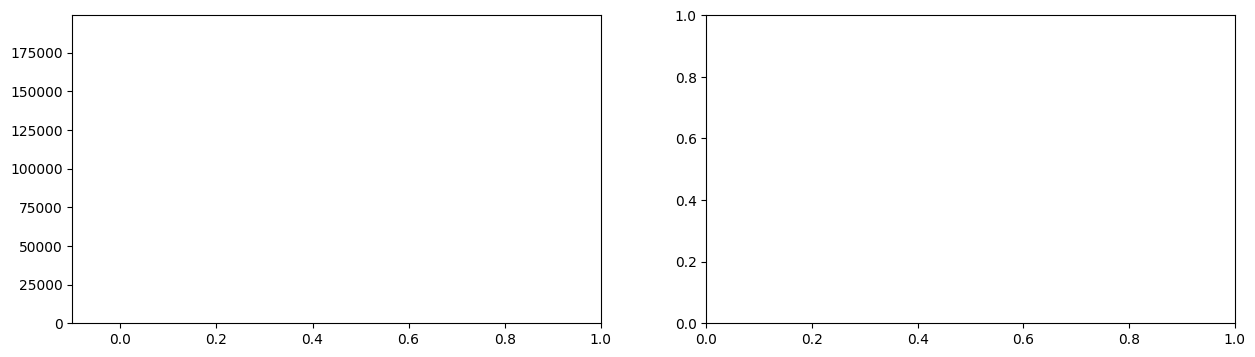

In [ ]:
# range_n_clusters = [5, 15, 25, 35, 45]

# # for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
# n_clusters = 25
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_size_inches(15, 4)

# # The 1st subplot is the silhouette plot
# # The silhouette coefficient can range from -1, 1 but in this example all
# # lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# # The (n_clusters+1)*10 is for inserting blank space between silhouette
# # plots of individual clusters, to demarcate them clearly.
# ax1.set_ylim([0, len(reduced_embeddings) + (n_clusters + 1) * 10])

# # Initialize the clusterer with n_clusters value and a random generator
# # seed of 10 for reproducibility.
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# cluster_assignments = kmeans.fit_predict(reduced_embeddings)

# # The silhouette_score gives the average value for all the samples.
# # This gives a perspective into the density and separation of the formed
# # clusters
# silhouette_avg = silhouette_score(reduced_embeddings, cluster_assignments)
# print(
#     "For n_clusters =",
#     n_clusters,
#     "The average silhouette_score is :",
#     silhouette_avg,
# )

# # Compute the silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(reduced_embeddings, cluster_assignments)

# y_lower = 10
# for i in range(n_clusters):
#     # Aggregate the silhouette scores for samples belonging to
#     # cluster i, and sort them
#     ith_cluster_silhouette_values = sample_silhouette_values[cluster_assignments == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = cm.nipy_spectral(float(i) / n_clusters)
#     ax1.fill_betweenx(
#         np.arange(y_lower, y_upper),
#         0,
#         ith_cluster_silhouette_values,
#         facecolor=color,
#         edgecolor=color,
#         alpha=0.7,
#     )

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples

# #ax1.set_title("The silhouette plot for the various clusters.")
# ax1.set_xlabel("The silhouette coefficient values")
# ax1.set_ylabel("Cluster label")

# # The vertical line for average silhouette score of all the values
# ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# ax1.set_yticks([])  # Clear the yaxis labels / ticks
# ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# # 2nd Plot showing the actual clusters formed
# colors = cm.nipy_spectral(cluster_assignments.astype(float) / n_clusters)
# ax2.scatter(
#     reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
# )

# # Labeling the clusters
# centers = kmeans.cluster_centers_
# # Draw white circles at cluster centers
# ax2.scatter(
#     centers[:, 0],
#     centers[:, 1],
#     marker="o",
#     c="white",
#     alpha=1,
#     s=200,
#     edgecolor="k",
# )

# for i, c in enumerate(centers):
#     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

# #ax2.set_title("The visualization of the clustered data.")
# ax2.set_xlabel("Feature space for the 1st feature")
# ax2.set_ylabel("Feature space for the 2nd feature")

# plt.suptitle(
#     "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#     % n_clusters,
#     fontsize=14,
#     fontweight="bold",
# )

# plt.show()

In [33]:
# Combine Original Embeddings and Cluster Features
enhanced_embeddings = np.hstack([embeddings, cluster_features])

In [34]:
# Load and Preprocess Labels (as before)
with open('icd_codes_1.txt') as f:
    labels_1 = [line.strip().split(';') for line in f]
with open('icd_codes_2.txt') as f:
    labels_2 = [line.strip().split(';') for line in f]
labels = labels_1 + labels_2

unique_labels = sorted(set(code for sublist in labels for code in sublist))
label_map = {code: idx for idx, code in enumerate(unique_labels)}
n_classes = len(unique_labels)

In [35]:
# Convert ICD10 codes to multi-hot vectors
multi_hot_labels = np.zeros((len(labels), n_classes))
for i, label_list in enumerate(labels):
    for label in label_list:
        if label in label_map:
            multi_hot_labels[i, label_map[label]] = 1

In [36]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(enhanced_embeddings, multi_hot_labels, test_size=0.15, random_state=42)

In [37]:
# Define Model with Enhanced Embeddings
def create_model(input_dim, output_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(output_dim, activation='sigmoid')
    ])
    return model

model = create_model(input_dim=1024 + n_clusters, output_dim=n_classes)  # Include the cluster feature dimension

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy',metrics.Precision(),metrics.Recall()])


In [38]:
# Train the Model
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/15
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0963 - loss: 0.0477 - precision_1: 0.0234 - recall_1: 0.0951 - val_accuracy: 0.4325 - val_loss: 0.0035 - val_precision_1: 0.8080 - val_recall_1: 0.4460
Epoch 2/15
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4205 - loss: 0.0041 - precision_1: 0.7804 - recall_1: 0.3720 - val_accuracy: 0.5286 - val_loss: 0.0026 - val_precision_1: 0.8233 - val_recall_1: 0.5951
Epoch 3/15
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4950 - loss: 0.0032 - precision_1: 0.8061 - recall_1: 0.4821 - val_accuracy: 0.5455 - val_loss: 0.0023 - val_precision_1: 0.8430 - val_recall_1: 0.6472
Epoch 4/15
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5215 - loss: 0.0028 - precision_1: 0.8202 - recall_1: 0.5369 - val_accuracy: 0.5568 - val_loss: 0.0021 - val_precision_1: 0.8406 - val_recall_1: 0.6762
Epoch 5/15
1322/1322 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5374 - loss: 0.0026 - precision_1: 0.8283 - rec

In [39]:
# Evaluation with Micro F2
def average_micro_f2(y_true, y_pred):
    y_pred = (y_pred > 0.43).astype(int)
    return f1_score(y_true, y_pred, average='micro')

In [40]:
# Predict and calculate F2
y_val_pred = model.predict(X_val)
f2_score_val = average_micro_f2(y_val, y_val_pred)
print(f"Validation Average Micro F2 Score: {f2_score_val:.4f}")

933/933 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation Average Micro F2 Score: 0.7935


In [41]:
# Step 1: Load the test embeddings
test_embeddings = np.load('test_data.npy')

In [42]:
# Dimensionality Reduction with PCA (Optional but recommended for clustering)
# Reduce to 50 components for clustering
reduced_test = pca.transform(test_embeddings)

In [43]:
# Clustering
cluster_test = kmeans.predict(reduced_test)

In [44]:
cluster_test_features = encoder.transform(cluster_test.reshape(-1, 1))

In [45]:
enhanced_test_embeddings = np.hstack([test_embeddings, cluster_test_features])

In [46]:
# Step 2: Make predictions on the test data
# Load the model (assuming you've already trained and saved it if needed)
y_test_pred = model.predict(enhanced_test_embeddings)

3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [56]:
# Step 3: Convert predictions to ICD10 code labels
# Apply threshold to determine which codes to include (e.g., 0.5 threshold)
threshold = 0.47
test_labels_pred = (y_test_pred > threshold).astype(int)

In [57]:
# Step 4: Create a submission file in the specified format
# Map indices back to ICD10 codes
index_to_code = {v: k for k, v in label_map.items()}

submission_data = []
for idx, label_vector in enumerate(test_labels_pred, start=1):
    # Get codes with predictions above the threshold and sort lexicographically
    codes = [index_to_code[i] for i, val in enumerate(label_vector) if val == 1]
    codes = sorted(codes)  # Sort lexicographically
    label_string = ';'.join(codes) if codes else ''  # Stitch with ';' or leave blank if no label
    submission_data.append({'id': idx, 'labels': label_string})

In [58]:
# Convert to DataFrame and save as CSV
submission_df = pd.DataFrame(submission_data)
submission_df

,id,labels
0,1,G56.01;G56.21
1,2,M65.9;S83.242A
2,3,G56.01
3,4,M65.312
4,5,S83.241A;S83.281A
...,...,...
99485,99486,D12.0;K57.30;K63.5
99486,99487,K31.89
99487,99488,D12.2;D12.5;Z12.11
99488,99489,B96.81;K21.9;K29.50


In [30]:
submission_df.to_csv('submission_cluster.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
